# GLASSY MODULUS

In [1]:
# import required packages

import traceback
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_squared_error,
    mean_absolute_error,
)
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import layers
from keras.regularizers import l2
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

### Data processing

In [2]:
# read data
filePath = r"C:\Users\Ama\OneDrive - Southern University System\01-Research\01-Data\01-Glassy_Modulus.csv"
df = pd.read_csv(filePath)

In [15]:
# Function to check if the number of SMILES corresponds to the number of entries in the ratio
def find_entries_with_difference(data):
    differing_entries = []
# Initialize an empty list to store differing entries
differing_entries = []

# Iterate through the DataFrame
for i, row in df.iterrows():
    smiles = row["SMILES"].split(',')
    ratios = row["Molar Ratio"].split(':')
    
    # Check if the number of SMILES is different from the number of ratios
    if len(smiles) != len(ratios):
        differing_entries.append((i + 1, row['Reference'], row["SMILES"], row["Molar Ratio"]))

# Print only the entries with differences
if differing_entries:
    print("Entries with differences in numbers of SMILES and ratios:")
    for line, reference, smiles, ratio in differing_entries:
        print(f"Line {line}: {reference}-{smiles} - {ratio}")
else:
    print("All entries have matching numbers of SMILES and ratios.")




Entries with differences in numbers of SMILES and ratios:
Line 41: Chen et al, 2018[28]-{CC(C)(c2ccc(OCC1CC1)cc2)c4ccc(OCC3CO3)cc4,O=C(O)CCCCCCCCC(=O)O, O=C(O)CCCCCCCCC(=O)O, O=C(O)C1CCC(C(=O)O)CC1} - 0.5:0.45:0.05
Line 42: Chen et al, 2018[28]-{CC(C)(c2ccc(OCC1CC1)cc2)c4ccc(OCC3CO3)cc4,O=C(O)CCCCCCCCC(=O)O, O=C(O)CCCCCCCCC(=O)O, O=C(O)C1CCC(C(=O)O)CC1} - 0.5:0.4:0.1
Line 46: Jo et al, 2018 [29]-{CC(C)(c4ccc(OCC(O)COc3ccc(C(C)(C)c2ccc(OCC1CO1)cc2)cc3)cc4)c6ccc(OCC5CO5)cc6, Nc2ccc(Cc1ccc(N)cc1)cc2, CC(N)COCC(C)N } - 0.66:0.21
Line 47: Jo et al, 2018 [29]-{CC(C)(c4ccc(OCC(O)COc3ccc(C(C)(C)c2ccc(OCC1CO1)cc2)cc3)cc4)c6ccc(OCC5CO5)cc6, Nc2ccc(Cc1ccc(N)cc1)cc2, CC(N)COCC(C)N } - 0.74:0.24
Line 48: Jo et al, 2018 [29]-{CC(C)(c4ccc(OCC(O)COc3ccc(C(C)(C)c2ccc(OCC1CO1)cc2)cc3)cc4)c6ccc(OCC5CO5)cc6, Nc2ccc(Cc1ccc(N)cc1)cc2, CC(N)COCC(C)N } - 0.71:0.23
Line 49: Jo et al, 2018 [29]-{CC(C)(c4ccc(OCC(O)COc3ccc(C(C)(C)c2ccc(OCC1CO1)cc2)cc3)cc4)c6ccc(OCC5CO5)cc6, Nc2ccc(Cc1ccc(N)cc1)cc2, CC(N)COCC(C)N 

In [21]:
#
smiles = df["SMILES"]
smiles = [list(smile.strip("{} ").split(",")) for smile in smiles]

molar_ratio = df["Molar Ratio"]
m_r = []
for entry in molar_ratio:
    ratio_list = [float(x) for x in entry.split(":")]
    m_r.append(ratio_list)

In [22]:
"""'
functions for fingerprinting and multiplication of 
fingerprinted monomers by their respective molar ratios
"""


# function for fingerprinting
def fingerprint_monomer(monomer):
    mol = Chem.MolFromSmiles(monomer)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 12, nBits=128)
    return fp


# function for storing fingerprints monomers as a representation of the polymers
def fingerprint_polymer(polymer):
    polymer_fp = []
    for monomer in polymer:
        monomer_fp = fingerprint_monomer(monomer)
        polymer_fp.append(monomer_fp)
    return polymer_fp


# function for multiplication by their respective molar ratios
def multiply_fingerprint(fp, m_r_value):
    return np.multiply(fp, m_r_value)


fingerprinted_polymer_data = []
for polymer, polymer_m_r in zip(smiles, m_r):
    fingerprinted_polymer = fingerprint_polymer(polymer)
    multiplied_polymer = [
        multiply_fingerprint(fp, m_r_value)
        for fp, m_r_value in zip(fingerprinted_polymer, polymer_m_r)
    ]
    fingerprinted_polymer_data.append(multiplied_polymer)


# flatten the array created and storing them in a list
flattened_arr = [np.concatenate(arr) for arr in fingerprinted_polymer_data]

# find the maximum length of the flattened arrays
max_length = max(len(arr) for arr in flattened_arr)

# pad the arrays with zeros to make them the same length
padded_arrays = [
    np.pad(arr, (0, max_length - len(arr)), mode="constant") for arr in flattened_arr
]

new_array = np.stack(padded_arrays)

In [23]:
X = new_array
y = df["Glassy Modulus(GPa)"]  # specify y

In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, shuffle=True
)

# # Initialize the scaler
# scaler = StandardScaler()

# # Fit the scaler on the training data and transform it
# X_train = scaler.fit_transform(X_train)

# # Apply the same transformation to the test data
# X_test= scaler.transform(X_test)

x_plot = np.linspace(0, 12)
y_plot = x_plot

### ANN Model

In [25]:
mycallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mape',
    min_delta=0.0001,
    patience=100,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

Epoch 1/500
8/8 [==============================] - 2s 66ms/step - loss: 3.4715 - mape: 89.9277 - val_loss: 4.2156 - val_mape: 76.7902
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 2.6308 - mape: 61.3421 - val_loss: 3.0250 - val_mape: 58.7363
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 2.3042 - mape: 69.6874 - val_loss: 3.0090 - val_mape: 52.4673
Epoch 4/500
8/8 [==============================] - 0s 16ms/step - loss: 2.1364 - mape: 51.7954 - val_loss: 2.9475 - val_mape: 48.6786
Epoch 5/500
8/8 [==============================] - 0s 13ms/step - loss: 2.0456 - mape: 48.8755 - val_loss: 2.8345 - val_mape: 48.5670
Epoch 6/500
8/8 [==============================] - 0s 13ms/step - loss: 1.9595 - mape: 46.3821 - val_loss: 2.6842 - val_mape: 47.0888
Epoch 7/500
8/8 [==============================] - 0s 15ms/step - loss: 1.8654 - mape: 42.3408 - val_loss: 2.5397 - val_mape: 44.2845
Epoch 8/500
8/8 [==============================] - 0s 14ms/ste

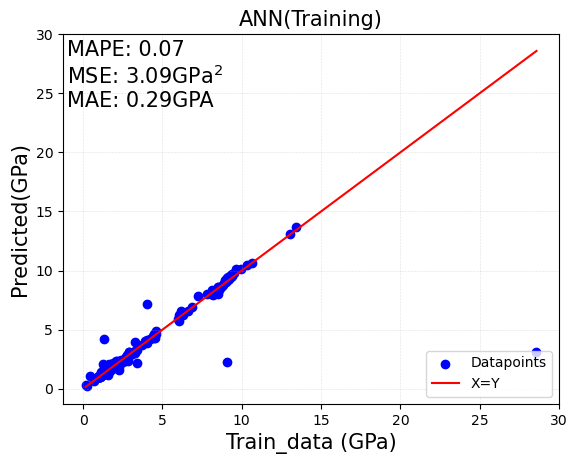

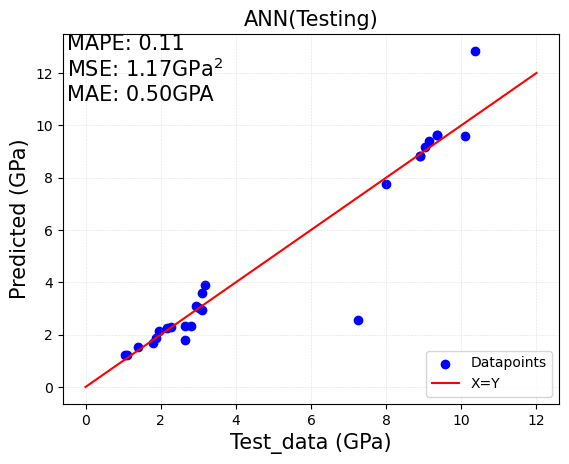

In [26]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Define the ANN model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ]
)

# Compile the model
model.compile(loss="mae", optimizer=optimizer, metrics=["mape"])

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[mycallback],
)
# Predict on the test set
predicted_values = model.predict(X_test)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the error
MAPE_train = mean_absolute_percentage_error(y_train, y_train_pred)
MAPE_test = mean_absolute_percentage_error(y_test, y_test_pred)

MSE_train = mean_squared_error(y_train, y_train_pred)
MSE_test = mean_squared_error(y_test, y_test_pred)

MAE_train = mean_absolute_error(y_train, y_train_pred)
MAE_test = mean_absolute_error(y_test, y_test_pred)


# Plot actual and predicted values for training set
plt.scatter(y_train, y_train_pred, color="b", label="Datapoints")
plt.plot(
    [min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", label="X=Y"
)
plt.xlabel("Train_data (GPa)", fontsize=15)
plt.ylabel("Predicted(GPa)", fontsize=15)
plt.text(
    -1,
    29.5,
    f"MAPE: {MAPE_train:.2f}\nMSE: {MSE_train:.2f}GPa$^2$\nMAE: {MAE_train:.2f}GPA",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Training)", fontsize=15)
# plt.legend()
plt.show()

plt.scatter(y_test, y_test_pred, color="b", label="Datapoints")
plt.plot(x_plot, y_plot, color="r", label="X=Y")
plt.xlabel("Test_data (GPa)", fontsize=15)
plt.ylabel("Predicted (GPa)", fontsize=15)
plt.text(
    -0.5,
    13.5,
    f"MAPE: {MAPE_test:.2f}\nMSE: {MSE_test:.2f}GPa$^2$\nMAE: {MAE_test:.2f}GPA",
    ha="left",
    va="top",
    fontsize=15,
)
plt.grid(True, which="both", linestyle="dotted", linewidth=0.4, alpha=0.7)
plt.legend(loc="lower right")
plt.title("ANN(Testing)", fontsize=15)
# plt.legend()
plt.show()

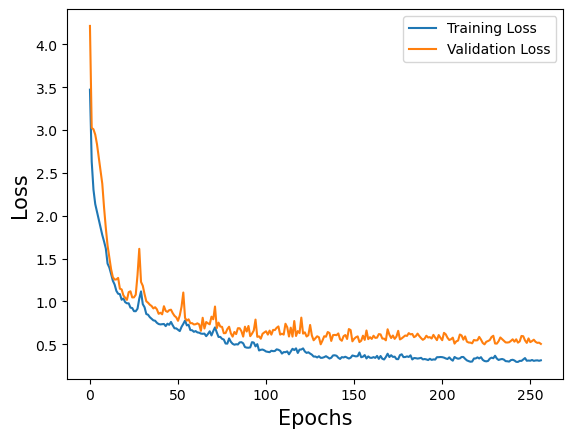

In [27]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.show()
